**File name**: prepare_dataset.ipynb<br>
**Authors**: Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;, Anton Lukashchuk &lt;[academik116@gmail.com](mailto:academik116@gmail.com)&gt;

This file is part of REDE project (https://github.com/akarazeev/REDE)

**Description**: content of this file was used to build a dataset called REDE - Reverse Engineering in Dispersion Engineering. Files from utils/matlab_data/ were used as raw data. These data contain information about system's simulations with given set of parameters.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
import tqdm
import pickle
import scipy.io as spio

In [7]:
%load_ext autoreload
%autoreload 2

from prepare_dataset_keras import preproc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def df_by_filepath(filepath):
    # Load data.
    mat = spio.loadmat(filepath, squeeze_me=True)

    struct = mat['str']
    header = ['id']
    header.extend(struct[0][1].dtype.names)
    header

    # Create DataFrame.
    dataset = []

    for i in range(len(struct)):
        tmp = [int(struct[i][0])]
        tmp.extend([float(struct[i][1][name]) for name in header[1:]])
        dataset.append(tmp)

    df_data = pd.DataFrame(data=dataset, columns=header)
    return df_data, struct

In [9]:
df_data, struct = df_by_filepath('matlab_data/keras_set1_1848+15-18+part_23-26.mat')
df_data[1000:1010]

,id,gap,width1,height,radius1,width2
1000,1227,4.000000e-07,0.000002,7.500000e-07,0.000020,8.800000e-07
1001,1228,4.000000e-07,0.000002,7.500000e-07,0.000020,9.200000e-07
1002,1229,4.000000e-07,0.000002,7.500000e-07,0.000020,9.600000e-07
1003,1230,4.000000e-07,0.000002,7.500000e-07,0.000020,1.000000e-06
1004,1231,4.000000e-07,0.000002,7.500000e-07,0.000022,8.000000e-07
1005,1232,4.000000e-07,0.000002,7.500000e-07,0.000022,8.400000e-07
1006,1233,4.000000e-07,0.000002,7.500000e-07,0.000022,8.800000e-07
1007,1234,4.000000e-07,0.000002,7.500000e-07,0.000022,9.200000e-07
1008,1235,4.000000e-07,0.000002,7.500000e-07,0.000022,9.600000e-07
1009,1236,4.000000e-07,0.000002,7.500000e-07,0.000022,1.000000e-06


In [10]:
# Generate dataset.
Disp = []
parameters_list = []
images = []

for filepath in ['matlab_data/keras_set1_1848+15-18+part_23-26.mat']:
    df_data, struct = df_by_filepath(filepath)

#     for i in tqdm.tqdm(range(len(struct))):
    for i in tqdm.tqdm(range(10)):
        # Parameters.
        sample_id = int(struct[i][0])
        parameters = df_data[df_data['id'] == sample_id].values[0][1:]
        ## get rid off bad samples with small radius
        if parameters[3]<17e-6:
            continue
        parameters_list.append(parameters)

        # Frequencies and modes.
        freqs, modes = struct[i][2][:, 0].real, struct[i][2][:, 2].real
#         frequencies_modes_list.append((freqs, modes))

        # Images.
        omega_total, delta_omega_total, freq_grid, Dint = preproc(freqs, modes)
        # Frequencies and modes write to the array to save them
#         freqs, modes = struct[i][2][:, 0].real, struct[i][2][:, 2].real
        Disp.append((freq_grid, Dint))
        
        fig = plt.figure(figsize=(2, 1))
        fig.add_subplot(111)
        plt.xlim((150, 400))
        plt.ylim((-500, 500))
        plt.axis('off')
        img = plt.scatter(omega_total * 1e-12, delta_omega_total * 1e-9, s=0.01)
        fig.canvas.draw()

        # Images -> arrays -> black and white.
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = data[5:-5, 20:-13, 0]
        data = (data < 200) * 255
        data = data.astype('uint8')
        images.append(data)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


In [51]:
len(images)

5070

In [56]:
a = np.random.randint(1,len(images),10)
a

array([4847, 3073,  346, 1706, 3268, 4485, 3885, 4607, 4734, 3770])

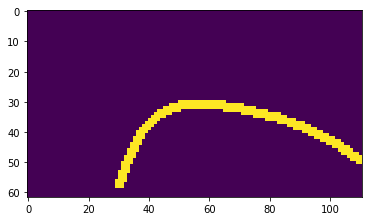

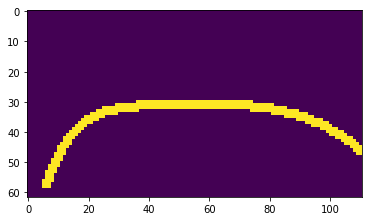

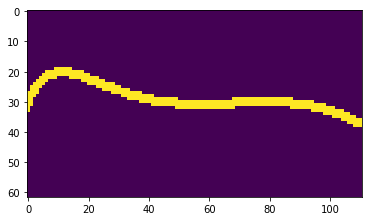

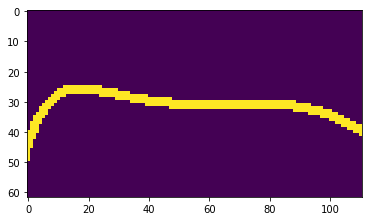

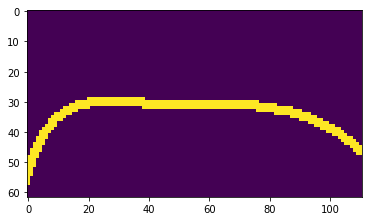

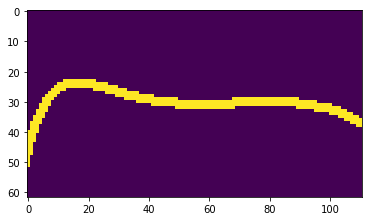

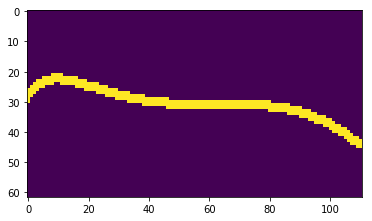

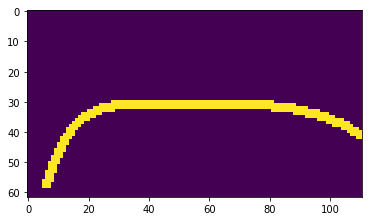

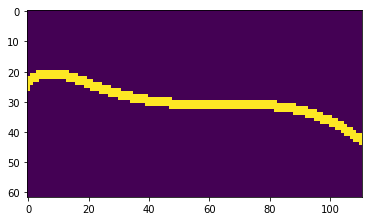

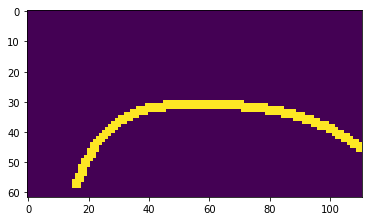

In [57]:
# for i in range(172, 180):
for i in a:
    plt.imshow(images[i])
    plt.show()

In [53]:
# Convert to np.array.
images = np.array(images)
Disp = np.array(Disp)
parameters_list = np.array(parameters_list)

with open('C:/Users/lukashch/Documents/GitHub/REDE/data/rede/raw/{}-5-parameters.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(parameters_list, f)

with open('C:/Users/lukashch/Documents/GitHub/REDE/data/rede/raw/{}-frequencies_modes.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(Disp, f)

with open('C:/Users/lukashch/Documents/GitHub/REDE/data/rede/raw/{}-62-111-images.pkl'.format(len(images)), 'wb') as f:
    pickle.dump(images, f)

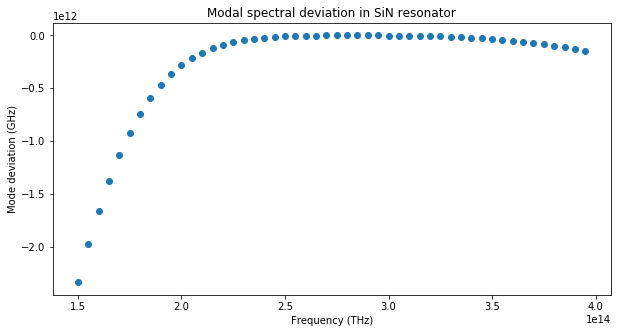

In [12]:
x, y = Disp[1]

plt.figure(figsize=(10,5))
plt.scatter(x, y)  # Plot each 300 data point.
plt.xlabel("Frequency (THz)")
plt.ylabel("Mode deviation (GHz)")
plt.title("Modal spectral deviation in SiN resonator")
plt.show()